In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob

In [2]:
sns.set_style(style="darkgrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
# Load summary data
print("\nLoading summary data...")
summary = pd.read_csv("../../data/summary.csv")
print(f"Total simulation runs: {len(summary)}")
print(f"\nColumns: {list(summary.columns)}")
print(f"\nFirst few rows:")
print(summary.head())


Loading summary data...
Total simulation runs: 200

Columns: ['scenario', 'guidance_law', 'duration', 'miss_distance', 'hit', 'timesteps']

First few rows:
   scenario guidance_law  duration  miss_distance  hit  timesteps
0  train_12          PPN      3.62           9.80    1      36221
1  train_75          PPN      5.64           9.97    1      56373
2  train_50          PPN      6.74           9.89    1      67430
3  train_43          PPN      7.16           9.96    1      71579
4  train_12          TPN      3.62           9.77    1      36222


In [4]:
# Summary statistics
print(f"\nSummary Statistics:")
print(f"   Total scenarios: {summary['scenario'].nunique()}")
print(f"   Guidance laws: {summary['guidance_law'].unique()}")
print(f"   Hit rate: {(summary['hit'].sum() / len(summary))*100:.1f}%")
print(f"   Hits: {summary['hit'].sum()}")
print(f"   Misses: {(summary['hit'] == 0).sum()}")
print(f"   Avg duration: {summary['duration'].mean():.2f}s")
print(f"   Avg timesteps: {summary['timesteps'].mean():.0f}")


Summary Statistics:
   Total scenarios: 100
   Guidance laws: ['PPN' 'TPN']
   Hit rate: 33.5%
   Hits: 67
   Misses: 133
   Avg duration: 22.12s
   Avg timesteps: 221223


In [5]:
# Hit rate by guidance law
print(f"\nHit Rate by Guidance Law:")
hit_by_guidance = summary.groupby('guidance_law').agg({
    'hit': ['sum', 'count', 'mean']
})
hit_by_guidance.columns = ['Hits', 'Total', 'Hit_Rate']
hit_by_guidance['Hit_Rate'] = hit_by_guidance['Hit_Rate'] * 100
print(hit_by_guidance)


Hit Rate by Guidance Law:
              Hits  Total  Hit_Rate
guidance_law                       
PPN             38    100      38.0
TPN             29    100      29.0


In [6]:
print("\nLoading trajectory CSV files...")

# Load only TPN files
csv_files = sorted(glob.glob("../../data/csv/*_TPN.csv"))
print(f"Found {len(csv_files)} TPN CSV files")

print("Loading first 50 files...")
dfs = []
for i, file in enumerate(csv_files[:50]):
    df = pd.read_csv(file)
    # Extract scenario name from filename (train_0_TPN.csv -> train_0)
    scenario_name = Path(file).stem.replace('_TPN', '')
    df['scenario'] = scenario_name
    dfs.append(df)
    if (i + 1) % 10 == 0:
        print(f"  Loaded {i+1} files...")

data = pd.concat(dfs, ignore_index=True)
print(f"\nTotal samples: {len(data):,}")
print(f"   Scenarios: {data['scenario'].nunique()}")
print(f"   Columns: {list(data.columns)}")

# Verify column structure
expected_cols = [
    'time', 'missile_x', 'missile_y', 'missile_z',
    'missile_vx', 'missile_vy', 'missile_vz',
    'target_x', 'target_y', 'target_z',
    'target_vx', 'target_vy', 'target_vz',
    'distance', 'acceleration', 'los_rate', 'closing_speed', 'hit'
]
assert all(col in data.columns for col in expected_cols), "Missing expected columns!"
print("All expected columns present")


Loading trajectory CSV files...
Found 100 TPN CSV files
Loading first 50 files...
  Loaded 10 files...
  Loaded 20 files...
  Loaded 30 files...
  Loaded 40 files...
  Loaded 50 files...

Total samples: 11,557,164
   Scenarios: 50
   Columns: ['time', 'missile_x', 'missile_y', 'missile_z', 'missile_vx', 'missile_vy', 'missile_vz', 'target_x', 'target_y', 'target_z', 'target_vx', 'target_vy', 'target_vz', 'distance', 'acceleration', 'los_rate', 'closing_speed', 'hit', 'scenario']
All expected columns present


In [7]:
print("\nData Quality Check:")

# Missing values
missing = data.isnull().sum()
if missing.sum() > 0:
    print("Missing values found:")
    print(missing[missing > 0])
else:
    print("No missing values")

# Check for infinities
inf_cols = []
for col in data.select_dtypes(include=[np.number]).columns:
    if np.isinf(data[col]).any():
        inf_cols.append(col)
if inf_cols:
    print(f"Infinite values found in: {inf_cols}")
else:
    print("No infinite values")

# Basic statistics
print(f"\nSummary statistics:")
print(data.describe())

# Per-scenario stats
print(f"\nPer-scenario statistics:")
scenario_stats = data.groupby('scenario').agg({
    'time': 'max',
    'distance': ['min', 'max', 'last'],
    'hit': 'first'
}).round(2)
scenario_stats.columns = ['Duration(s)', 'Min_Dist(m)', 'Max_Dist(m)', 'Final_Dist(m)', 'Hit']
print(scenario_stats)


Data Quality Check:
No missing values
No infinite values

Summary statistics:
               time     missile_x     missile_y     missile_z    missile_vx  \
count  1.155716e+07  1.155716e+07  1.155716e+07  1.155716e+07  1.155716e+07   
mean   1.421202e+01  2.972447e+03  9.518395e+02  4.340363e+03  2.252199e+02   
std    8.822575e+00  1.777960e+04  5.082271e+03  1.849811e+04  1.059655e+03   
min    0.000000e+00 -6.307688e+04 -2.608296e+04 -5.154042e+04 -2.243890e+03   
25%    6.294300e+00 -3.509715e+03 -8.526040e+02 -5.099274e+03 -6.506849e+02   
50%    1.396570e+01  1.182747e+03  1.418903e+03  2.595813e+03  2.582098e+02   
75%    2.182690e+01  1.217797e+04  3.062135e+03  1.611286e+04  1.077064e+03   
max    3.000010e+01  6.105729e+04  2.034919e+04  6.116824e+04  2.373143e+03   

         missile_vy    missile_vz      target_x      target_y      target_z  \
count  1.155716e+07  1.155716e+07  1.155716e+07  1.155716e+07  1.155716e+07   
mean  -3.817342e+01  2.783022e+02 -3.212947e+03  1.


Generating distribution plots...


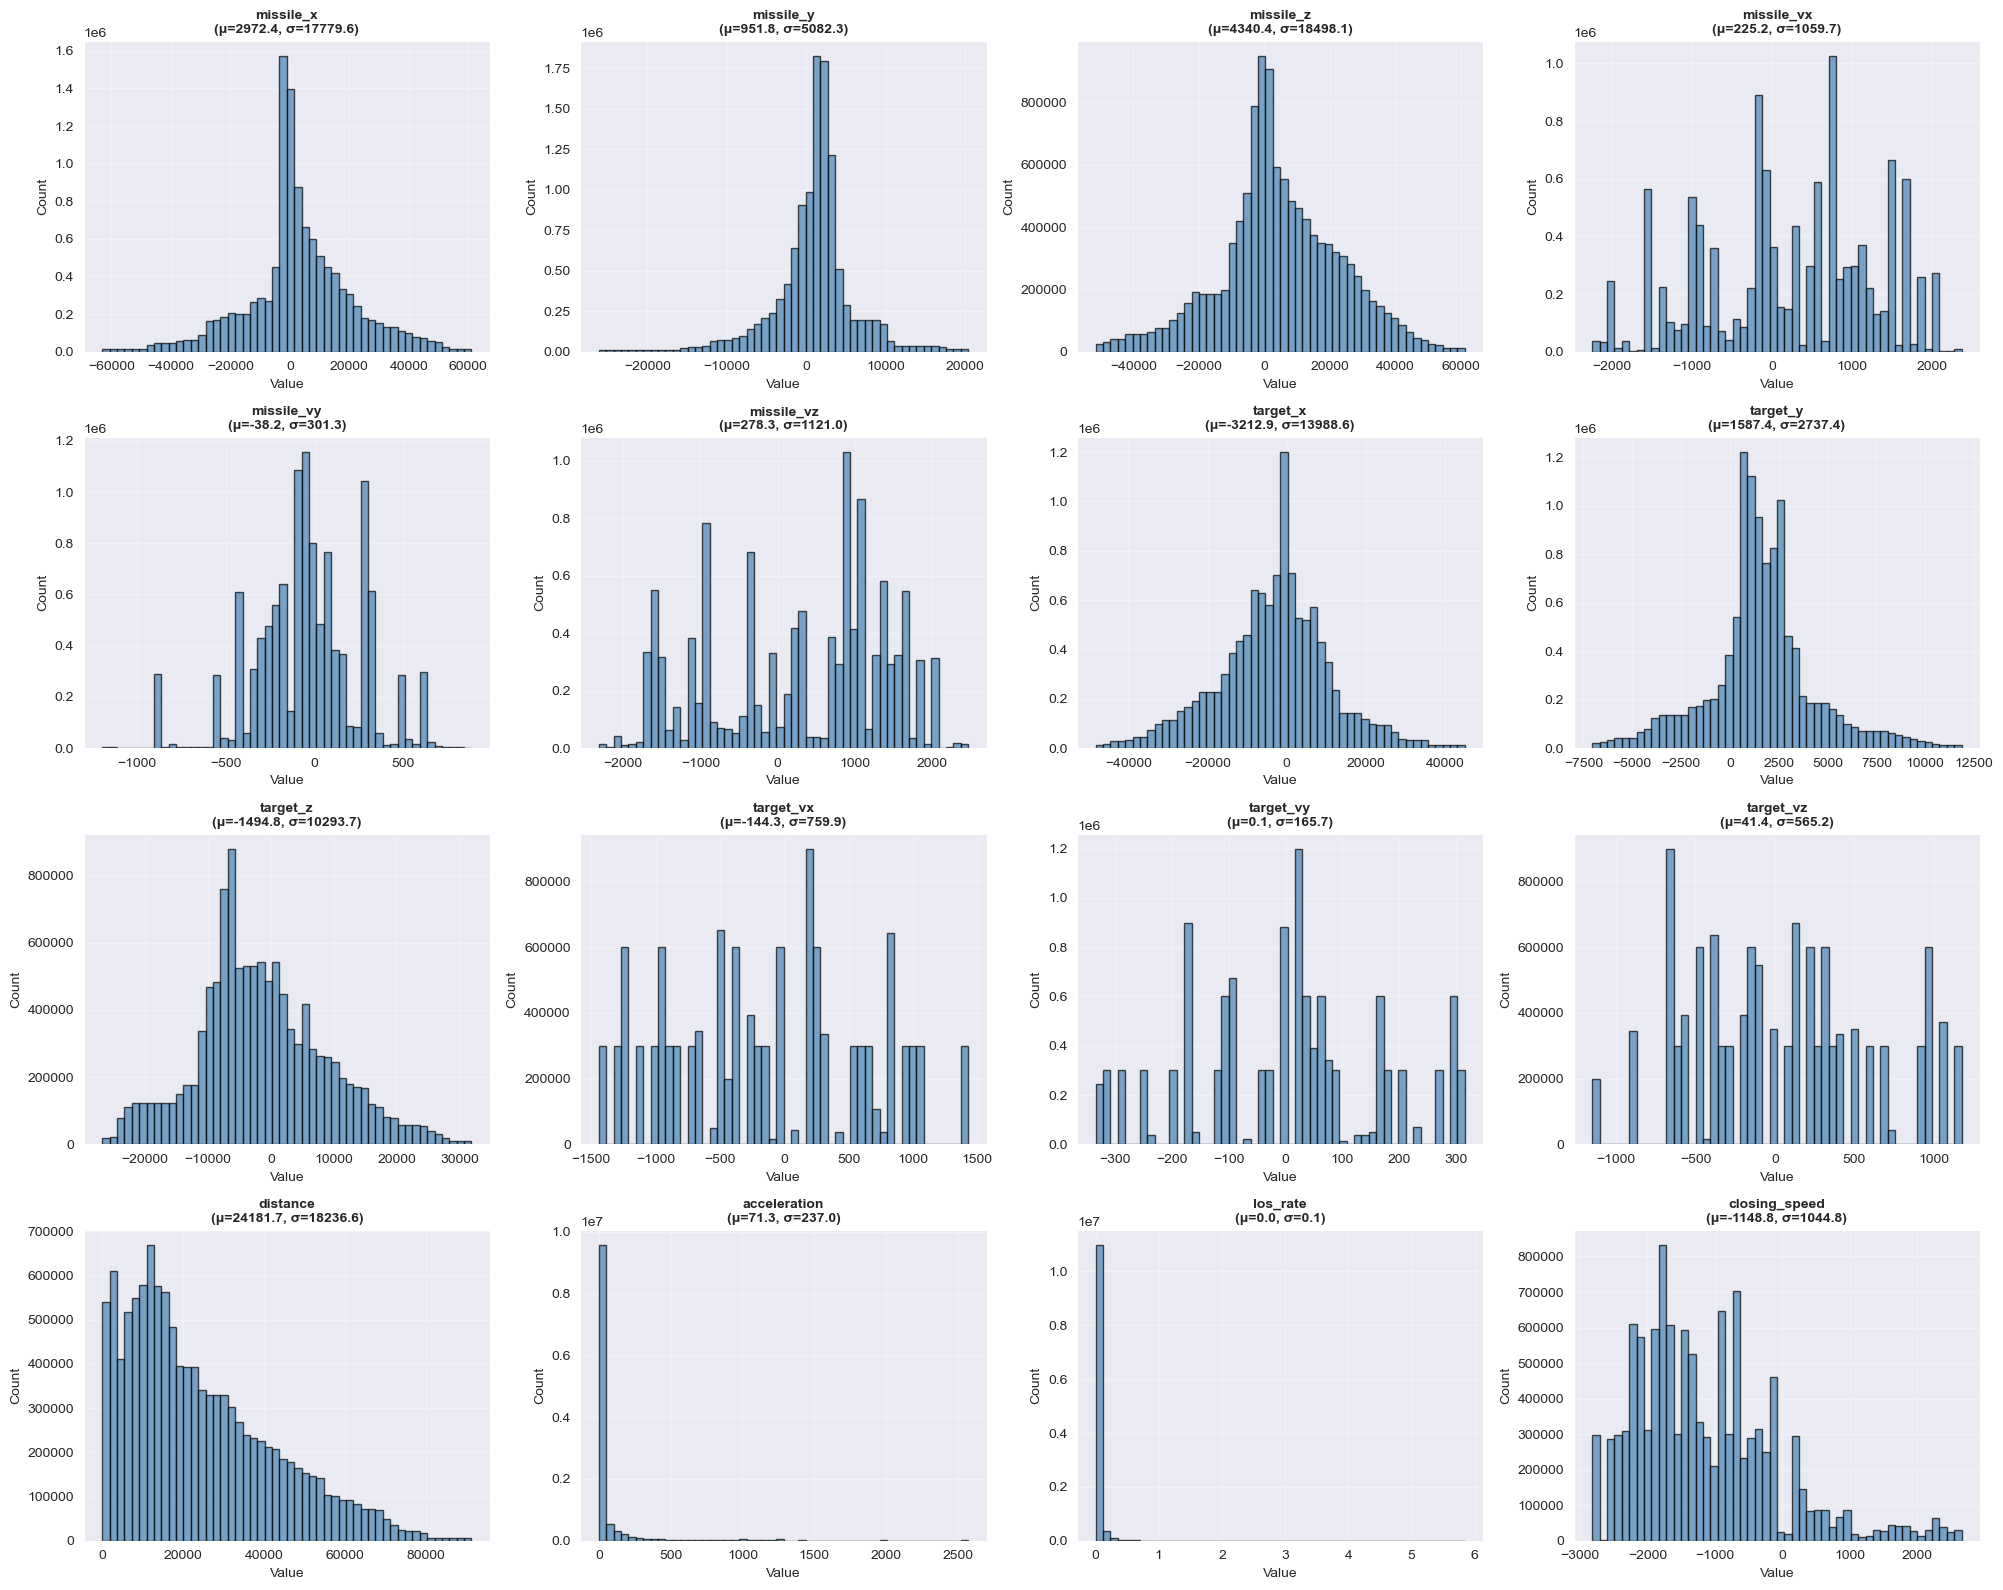

In [8]:
print("\nGenerating distribution plots...")

feature_cols = [
    'missile_x', 'missile_y', 'missile_z',
    'missile_vx', 'missile_vy', 'missile_vz',
    'target_x', 'target_y', 'target_z',
    'target_vx', 'target_vy', 'target_vz',
    'distance', 'acceleration', 'los_rate', 'closing_speed'
]

fig, axes = plt.subplots(4, 4, figsize=(20, 16))
axes = axes.flatten()

for i, col in enumerate(feature_cols):
    if i < len(axes):
        axes[i].hist(data[col].dropna(), bins=50, alpha=0.7, edgecolor='black', color='steelblue')
        axes[i].set_title(f'{col}\n(μ={data[col].mean():.1f}, σ={data[col].std():.1f})', 
                         fontsize=10, fontweight='bold')
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Count')
        axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('plots/data_distributions.png', dpi=150, bbox_inches='tight')


Visualizing sample trajectories...
   Found 15 hit scenarios, 35 miss scenarios


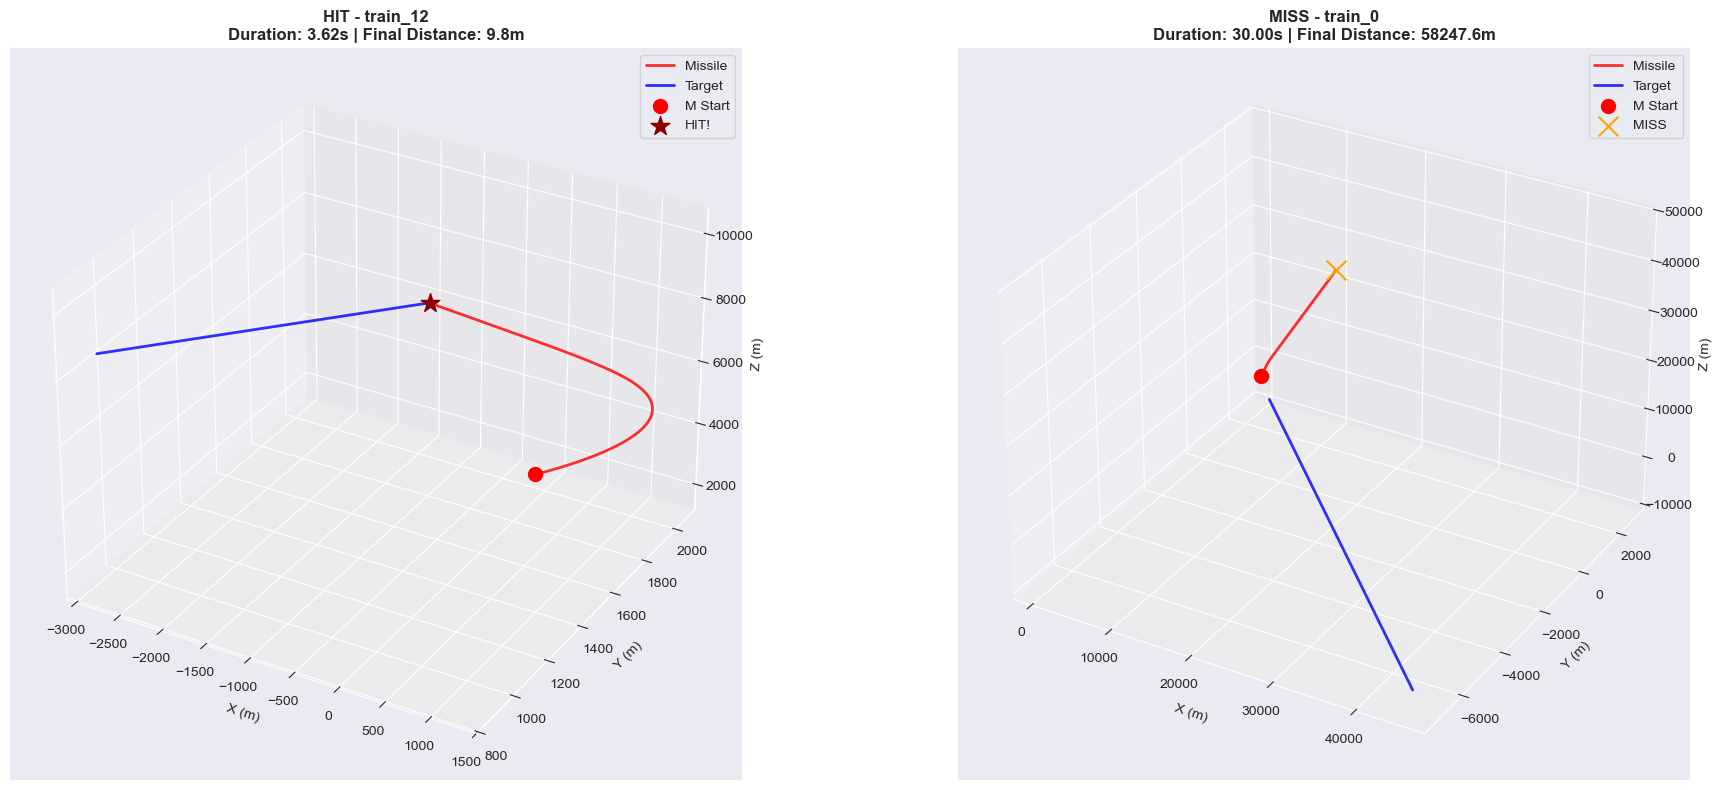

In [9]:
print("\nVisualizing sample trajectories...")

# Get hit and miss scenarios from loaded data
hit_scenarios = data[data.groupby('scenario')['hit'].transform('first') == 1]['scenario'].unique()
miss_scenarios = data[data.groupby('scenario')['hit'].transform('first') == 0]['scenario'].unique()

print(f"   Found {len(hit_scenarios)} hit scenarios, {len(miss_scenarios)} miss scenarios")

fig = plt.figure(figsize=(20, 8))

# Plot HIT trajectory
if len(hit_scenarios) > 0:
    ax1 = fig.add_subplot(121, projection='3d')
    hit_data = data[data['scenario'] == hit_scenarios[0]]
    
    ax1.plot(hit_data['missile_x'], hit_data['missile_y'], hit_data['missile_z'], 
             'r-', linewidth=2, label='Missile', alpha=0.8)
    ax1.plot(hit_data['target_x'], hit_data['target_y'], hit_data['target_z'], 
             'b-', linewidth=2, label='Target', alpha=0.8)
    ax1.scatter(hit_data['missile_x'].iloc[0], hit_data['missile_y'].iloc[0], 
                hit_data['missile_z'].iloc[0], c='red', s=100, marker='o', label='M Start')
    ax1.scatter(hit_data['missile_x'].iloc[-1], hit_data['missile_y'].iloc[-1], 
                hit_data['missile_z'].iloc[-1], c='darkred', s=200, marker='*', label='HIT!')
    
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('Y (m)')
    ax1.set_zlabel('Z (m)')
    ax1.set_title(f'HIT - {hit_scenarios[0]}\n'
                  f'Duration: {hit_data["time"].max():.2f}s | '
                  f'Final Distance: {hit_data["distance"].iloc[-1]:.1f}m', 
                  fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

# Plot MISS trajectory
if len(miss_scenarios) > 0:
    ax2 = fig.add_subplot(122, projection='3d')
    miss_data = data[data['scenario'] == miss_scenarios[0]]
    
    ax2.plot(miss_data['missile_x'], miss_data['missile_y'], miss_data['missile_z'], 
             'r-', linewidth=2, label='Missile', alpha=0.8)
    ax2.plot(miss_data['target_x'], miss_data['target_y'], miss_data['target_z'], 
             'b-', linewidth=2, label='Target', alpha=0.8)
    ax2.scatter(miss_data['missile_x'].iloc[0], miss_data['missile_y'].iloc[0], 
                miss_data['missile_z'].iloc[0], c='red', s=100, marker='o', label='M Start')
    ax2.scatter(miss_data['missile_x'].iloc[-1], miss_data['missile_y'].iloc[-1], 
                miss_data['missile_z'].iloc[-1], c='orange', s=200, marker='x', label='MISS')
    
    ax2.set_xlabel('X (m)')
    ax2.set_ylabel('Y (m)')
    ax2.set_zlabel('Z (m)')
    ax2.set_title(f'MISS - {miss_scenarios[0]}\n'
                  f'Duration: {miss_data["time"].max():.2f}s | '
                  f'Final Distance: {miss_data["distance"].iloc[-1]:.1f}m', 
                  fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/sample_trajectories.png', dpi=150, bbox_inches='tight')


Computing feature correlations...


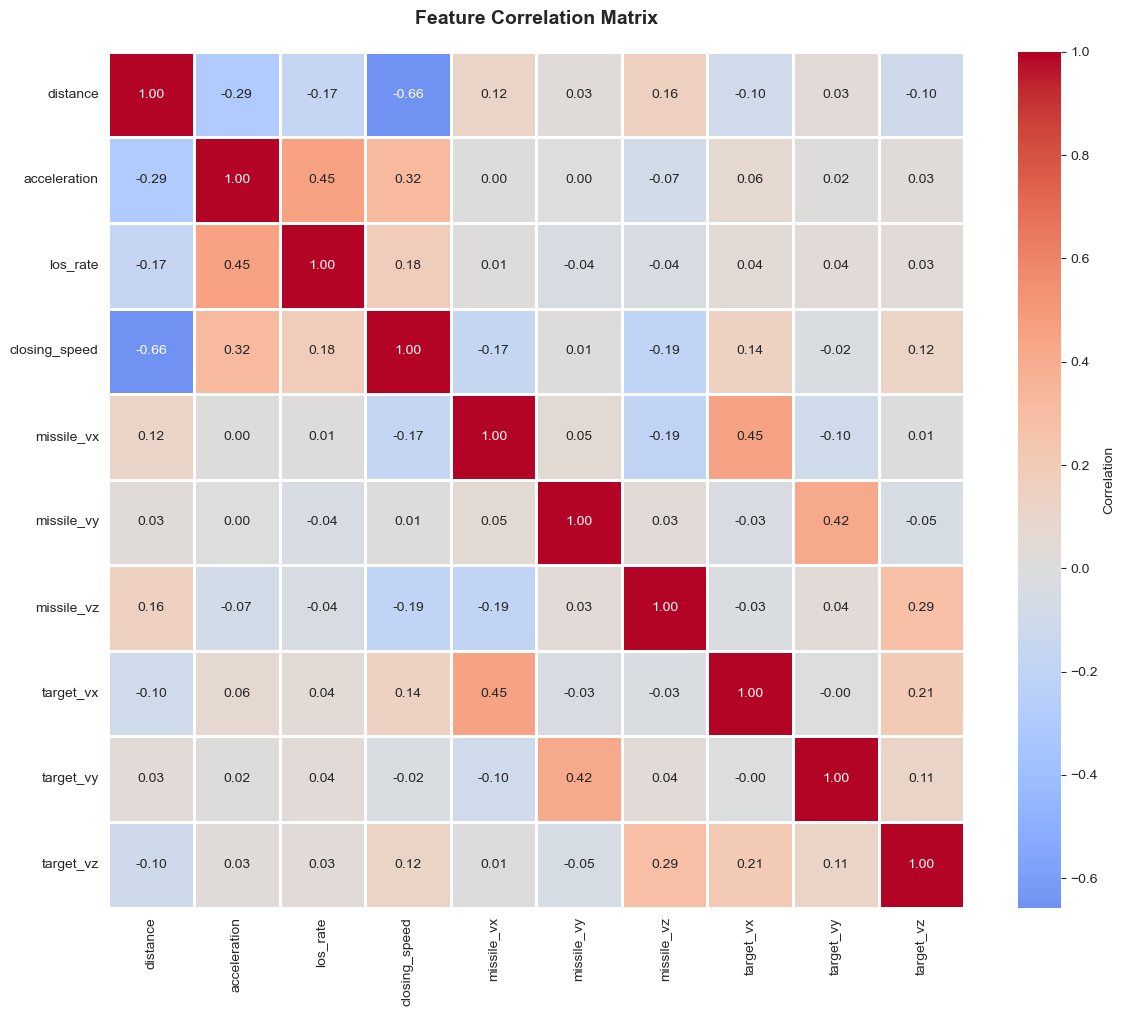

In [10]:
print("\nComputing feature correlations...")

corr_features = [
    'distance', 'acceleration', 'los_rate', 'closing_speed',
    'missile_vx', 'missile_vy', 'missile_vz',
    'target_vx', 'target_vy', 'target_vz'
]

# Sample data for faster correlation computation
sample_data = data.sample(min(10000, len(data)), random_state=42)
corr_matrix = sample_data[corr_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={'label': 'Correlation'})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('plots/feature_correlations.png', dpi=150, bbox_inches='tight')


 Temporal analysis...


C:\Users\ronak\AppData\Local\Temp\ipykernel_7532\3401940061.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temporal_stats = data.groupby('time_bin').agg({


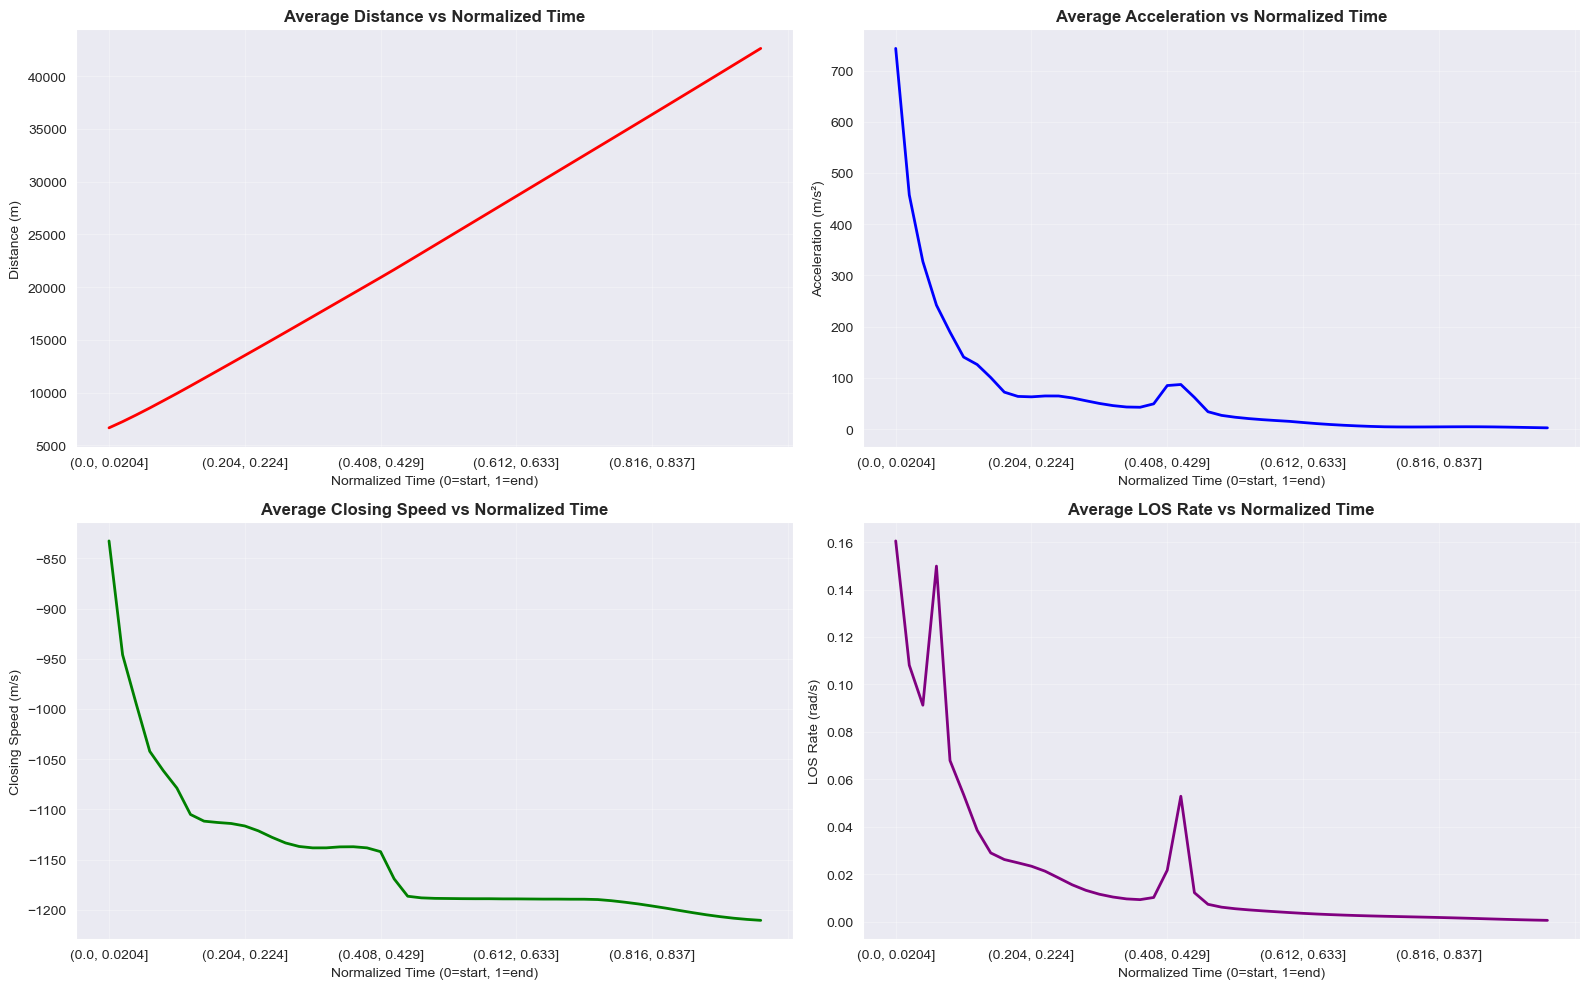

In [11]:
print("\n Temporal analysis...")

# Average metrics over time (normalized time 0-1 for comparison)
data['time_normalized'] = data.groupby('scenario')['time'].transform(lambda x: x / x.max())
time_bins = np.linspace(0, 1, 50)
data['time_bin'] = pd.cut(data['time_normalized'], bins=time_bins)

temporal_stats = data.groupby('time_bin').agg({
    'distance': 'mean',
    'acceleration': 'mean',
    'closing_speed': 'mean',
    'los_rate': 'mean'
})

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

temporal_stats['distance'].plot(ax=axes[0,0], color='red', linewidth=2)
axes[0,0].set_title('Average Distance vs Normalized Time', fontweight='bold')
axes[0,0].set_ylabel('Distance (m)')
axes[0,0].set_xlabel('Normalized Time (0=start, 1=end)')
axes[0,0].grid(alpha=0.3)

temporal_stats['acceleration'].plot(ax=axes[0,1], color='blue', linewidth=2)
axes[0,1].set_title('Average Acceleration vs Normalized Time', fontweight='bold')
axes[0,1].set_ylabel('Acceleration (m/s²)')
axes[0,1].set_xlabel('Normalized Time (0=start, 1=end)')
axes[0,1].grid(alpha=0.3)

temporal_stats['closing_speed'].plot(ax=axes[1,0], color='green', linewidth=2)
axes[1,0].set_title('Average Closing Speed vs Normalized Time', fontweight='bold')
axes[1,0].set_ylabel('Closing Speed (m/s)')
axes[1,0].set_xlabel('Normalized Time (0=start, 1=end)')
axes[1,0].grid(alpha=0.3)

temporal_stats['los_rate'].plot(ax=axes[1,1], color='purple', linewidth=2)
axes[1,1].set_title('Average LOS Rate vs Normalized Time', fontweight='bold')
axes[1,1].set_ylabel('LOS Rate (rad/s)')
axes[1,1].set_xlabel('Normalized Time (0=start, 1=end)')
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('plots/temporal_analysis.png', dpi=150, bbox_inches='tight')

In [12]:
print("DATA EXPLORATION SUMMARY")
print("="*60)
print(f"Total trajectory samples: {len(data):,}")
print(f"Scenarios loaded: {data['scenario'].nunique()}")
print(f"Hit rate (loaded scenarios): {(data.groupby('scenario')['hit'].first().sum() / data['scenario'].nunique())*100:.1f}%")
print(f"Average trajectory length: {data.groupby('scenario').size().mean():.0f} timesteps")
print(f"Time range: 0 to {data['time'].max():.2f}s")
print(f"Distance range: {data['distance'].min():.1f}m to {data['distance'].max():.1f}m")
print("="*60)

DATA EXPLORATION SUMMARY
Total trajectory samples: 11,557,164
Scenarios loaded: 50
Hit rate (loaded scenarios): 30.0%
Average trajectory length: 231143 timesteps
Time range: 0 to 30.00s
Distance range: 9.8m to 91218.4m
